# Derterminers of Houseprices: a linear regression model

In the following we are using linear regression to predict house prices. We use a dataframe of houses in King County, USA as data base. The data is observed, transformed, fed into the model. Afterwards we remove non-significant features to optain the final Model.

## Libraries

In [1155]:
import pandas as pd
import getpass
import sqlalchemy as sa
import numpy as np
import seaborn as sns
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import RFE
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

## Functions

In [1156]:
## functions:
def load_df():
    """Load from path Data/house_price_df.csv"""
    return pd.read_csv('Data/house_price_df.csv')


In [1157]:
def add_distance():
    """load distance df from 'Data/distance.csv', distanceM as float"""
    distance = pd.read_csv('Data/distance.csv')
    distance = distance['DistanceM'].astype('float64')
    return distance

In [1158]:
def change_to_cat(ordinal_var):
    """change input to type category"""
    return hp_df[ordinal_var].astype('category')

In [1159]:
def print_cor_mat(df):
    """prtin the correlation heatmap of numerical variables of a dataframe"""
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(9, 7))
        ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [1160]:
def get_num_attributes(df):
    """returns all numerical attributes of the dataframe"""
    return df.select_dtypes(['int64','float'])

In [1161]:
def print_hist(df):
    """ print histograms of the input dataframe"""
    return get_num_attributes(df).hist(figsize=(12,12), bins=40)

In [1162]:
def transform_num_attr(df, method='qt'):
    """
    Transforms the input dataframe using the method specified. Standard is 'qt' = QuantileTransformer.
    Returns the dataframed with transformed columns and the names of the transformed columns in a list (trans_cols).
    """
    df,y=Xy_split(hp_df, 'price') #remove 'price'
    num_cols = list(get_num_attributes(df).columns)
    to_trans={}
    for key in num_cols:
        to_trans[key]= method
    pt = PowerTransformer()
    qt = QuantileTransformer(output_distribution="normal")
    
    transformed_cols = []
    col_name = []
    for i in to_trans.keys():
        if list(to_trans.values())[0] == 'pt':
            transformed = pt.fit_transform(df[i].to_numpy().reshape(-1,1))
        elif list(to_trans.values())[0] == 'qt':
            transformed = qt.fit_transform(df[i].to_numpy().reshape(-1,1))
        else: 
            print('no transformer could be identified')
        col_name = i+'_transformed'
        #sns.displot(transformed).set(title=f'Histogram of {col_name}')
        df[col_name] = transformed
        transformed_cols = transformed_cols + [col_name]
        df.drop(i, axis= 1, inplace=True)
    return df, transformed_cols


In [1163]:
def drop_above_threshold(df, threshold):
    """Drops the attributes of the dataframe that have a higher correlation then the specified threshold"""
    corr_matrix=hp_df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    corr_var = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return df.drop(corr_var, axis= 1)

In [1164]:
def remove_outlier(df_in, col_name, threshold=2):
    """ removes the outliers of the specified col_name returns a datframe with removed rows """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-threshold*iqr
    fence_high = q3+threshold*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [1165]:
def get_cat_attr(df):
    """return category and object attributes from given dataframe"""
    return df.select_dtypes(['object', 'category'])

In [1166]:
def transform_to_dummies(df):
    """returns a dataframe where attributes of type category or object are returned in a one-hot enoced dataframe.
    Also returns dummies as a datframe that only contains the transformed attributes """
    col_names_object = list(get_cat_attr(df).columns)
    print(col_names_object)
    dummies= pd.get_dummies(df[col_names_object] , drop_first=True)
    df = df.drop(col_names_object, axis = 1)
    df[dummies.columns] = dummies
    return df, dummies

In [1167]:
def Xy_split(df, output_col):
    """ Split the dataset into:
        X = dataframe of input variables
        y = predicted variable
    """
    X=df.drop(output_col, axis=1)
    y=df[output_col]
    return X, y

In [1168]:
def scale_df(X_train, X_test, X):
    """ Scales the input dataframes X_train and X_test. Requires the original X dataframe"""
    std_scaler=StandardScaler().fit(get_num_attributes(X_train))
    X_train_scaled=std_scaler.transform(get_num_attributes(X_train))
    X_test_scaled=std_scaler.transform(get_num_attributes(X_test))
    X_train_scaled = np.concatenate((X_train_scaled, np.asarray(X_train[dummies.columns])), axis = 1) 
    X_test_scaled = np.concatenate((X_test_scaled, np.asarray(X_test[dummies.columns])), axis =1)
    print(X_train_scaled.shape, X_test_scaled.shape)
    return X_test_scaled, X_train_scaled

In [1169]:
def model_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    """returns model, y_pred and y_pred_train from X_train_scaled, X_test_scaled, y_train, y_test"""
    model=LinearRegression()    # model
    model.fit(X_train_scaled, y_train)
    y_pred=model.predict(X_test_scaled)   # model prediction
    y_pred_train=model.predict(X_train_scaled)
    return model, y_pred, y_pred_train

In [1170]:
def plot_model_stats(y_test, y_pred):
    """Plots:
    1. Test Set -Predicted vs real
    2. Test Set Residual histogram
    3. Residuals by Predicted
    """
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(y_pred, y_test, 'o')
    ax[0].set_xlabel("y_test")
    ax[0].set_ylabel("y_pred")
    ax[0].set_title("Test Set -Predicted vs real")

    ax[1].hist(y_test - y_pred)
    ax[1].set_xlabel("Test y-y_pred")
    ax[1].set_title("Test Set Residual histogram")

    ax[2].plot(y_pred,y_test - y_pred,"o")
    ax[2].set_xlabel("predicted")
    ax[2].set_ylabel("residuals")
    ax[2].set_title("Residuals by Predicted")
    ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

In [1171]:
def get_testresults(X_train_scaled, X_test_scaled, X_test, y_test, y_pred, y_pred_train):
    """ Returns a dataframe of important test statistics of linear regression"""
    mse_test = mse(y_test, y_pred)
    mse_train = mse(y_train, y_pred_train)
    rmse_test = np.sqrt(mse(y_test, y_pred))
    mae_test = mae(y_test, y_pred)
    R2_test=model.score(X_test_scaled,y_test)
    R2_train=model.score(X_train_scaled,y_train)
    Adj_R2= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    dest_stats = {'mse_train': mse_train,\
             'mse_test': mse_test,\
             'rmse_test': rmse_test,\
             'mae_test': mae_test,\
             'R2_test': R2_test,\
             'R2_train': R2_train,\
             'Adj_R2': Adj_R2}
    return pd.DataFrame(dest_stats, index=[0])

In [1172]:
def get_model_coef(X_train, model):
    """gets model coeficients and saves them in a dataframe"""
    return pd.DataFrame(data={
        'Attribute': X_train.columns,
        'coef': model.coef_})

In [1173]:
def drop_non_significant(X, m1_pvalues, threshold=0.05):
    """Returns a datframe without attributes that are not siginificant """
    X_dropped_p = X.drop(X[list(m1_pvalues['Attribute'][m1_pvalues['pvalue']>threshold])], axis=1)
    print(f'From orginally {X.shape[1]} features {X_dropped_p.shape[1]} features remain.')
    return X_dropped_p

In [1174]:
def get_feature_importance(X_train, model):
    """ returns a Dataframe of the absolutes of the model coeficients"""
    return pd.DataFrame(data={
        'Attribute': X_train.columns,
        'Importance': abs(model.coef_)
    })

In [1175]:
def plot_feature_importance(feature_importance):  
    """Plots the importance of the features sorted descending"""
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(21,14))
    plt.bar(x=feature_importance['Attribute'], height=feature_importance['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(20,50))
    plt.show()

In [1176]:
def get_pvalues(X_train, X_train_scaled, y_train):
    """returns a dataframe of pvalues, attributes and coeficients"""
    X_train_const_scaled = sm.add_constant(X_train_scaled) #getting model using sm.Ols (more detailed statistics)
    reg_model = sm.OLS(y_train, X_train_const_scaled).fit()
    p_values = reg_model.pvalues
    #print(len(['const'] + list(X_train.columns)), len(p_values), len(p_values.index))
    return pd.DataFrame(data= {
        'Attribute':['const'] + list(X_train.columns),
        'pvalue': p_values,
        'coef':p_values.index})



## Importing Dataset.

In [1177]:
hp_df = load_df()

# EDA

## Overview

In [1178]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21597 non-null  int64  
 1   id             21597 non-null  int64  
 2   date           21597 non-null  object 
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The Dataset consists of 21597 Houses containing 21 features. Price is to be the predicted variables. 

In [1179]:
hp_df.describe()

,Unnamed: 0,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,10798.000000,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,...,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,6234.661218,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,...,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,0.000000,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,5399.000000,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,10798.000000,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,...,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,16197.000000,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,...,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,21596.000000,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


The average house has about 3 bedrooms, 2080 sqft of living area, a lot size of 15000 sqft, was built in 1970 and has a price of 540000 $. The mean and the median differ alot in the variable sqft lot, where the median is much lower then the mean. This leads to the conculusion that many houses don't have a big lot but a few house with a big lot change the distribution.

In [1180]:
# sns.pairplot(hp_df) #To view remove comment. Commented to get higher performance

The Pairplot gives first interesting insides. Obviously there are linear tendencies between variables of size like lot size, size of living room. Many variables are categorical or boolean and should be transformed.

## Taking a closer look at certain variables/Feature engineering

### Date

In [1181]:
print(hp_df['date'].min(), hp_df['date'].max())

2014-05-02 2015-05-27


The date variable displays the date when the house was sold. Data is between May 2014 and May 2015. 

### Bathrooms

In [1182]:
hp_df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

Most houses have 2,5 bathrooms, a lot also only . A view outliers have a very high number of bathrooms.

## Location

For the location the datasets offers three features. Latitute and Longitude (only useful combined) and zipcodes. Let's look at both of them.

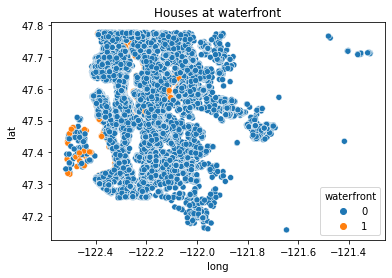

In [1183]:
 sns.scatterplot(data=hp_df, x='long', y='lat', hue = 'waterfront').set(title='Houses at waterfront')
plt.savefig('Data/waterfront houses.png')

Looking at the geographical location of the houses and displaying the lot size it is visual, that the properties at the are outskirts and the countryside get bigger. 

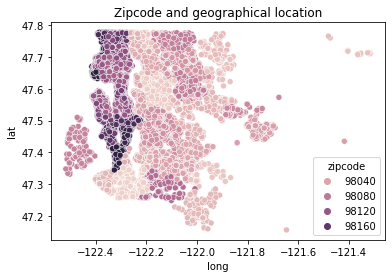

In [1184]:
 sns.scatterplot(data=hp_df, x='long', y='lat', hue = 'zipcode').set(title='Zipcode and geographical location')
plt.savefig('Data/Zipcode and geographical location.png')

The zipcodes are not in a logical order so the variables should not be used as numerical variables.
And alternative idea would be to use the travel distance from the house to the city center. 

Data was optained from Google Distance Matrix API. 
['Get distance'](https://github.com/CrisQueCris/Houseprices/blob/main/Get%20Traveldistance%20to%20Seattle%20City%20Center.ipynb)

In [1185]:
distance = pd.read_csv('Data/distance.csv')

In [1186]:
hp_df['distanceM'] = add_distance()

In [1187]:
hp_df['distanceM']

0        18112.0
1        14155.0
2        25519.0
3        17950.0
4        33624.0
          ...   
21592     9458.0
21593    15749.0
21594     8836.0
21595    30793.0
21596     8869.0
Name: distanceM, Length: 21597, dtype: float64

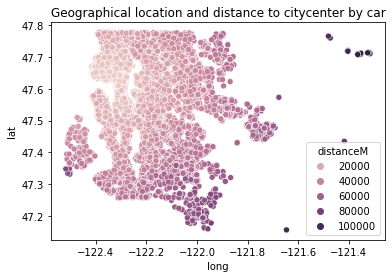

In [1188]:
sns.scatterplot(data=hp_df, x='long', y='lat', hue = 'distanceM').set(title='Geographical location and distance to citycenter by car')
plt.savefig('lcoation and distanceM.png')

## Year renovated

[Text(0.5, 1.0, 'Histogram of Year renovated')]

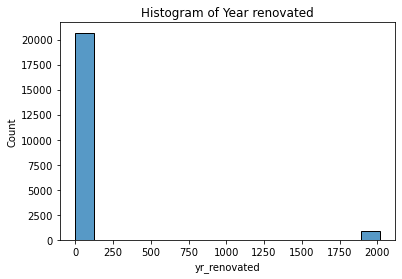

In [1189]:
sns.histplot(data=hp_df, x='yr_renovated').set(title= 'Histogram of Year renovated')

The year renovated displays a 0 if the house was not yet renovated. This is not useful information in a linear regression. 

Workaround:

introduce boolean variable: Renovated: Yes/N0
Put zero values as No  


In [1190]:
hp_df['renovated'] = bool

In [1191]:
hp_df.loc[hp_df['yr_renovated'] == 0, 'renovated'] = False

In [1192]:
hp_df.loc[hp_df['yr_renovated'] != 0, 'renovated'] = True

## Basement

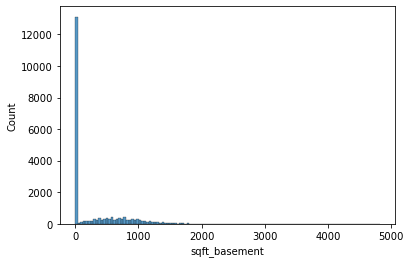

In [1193]:
plot_dist_basement = sns.histplot(data=hp_df, x='sqft_basement')
plt.savefig('Data/dist_basement.png')

Most Houses don't have a basement, so a dummy will be introduced checking for basement or not:

In [1194]:
hp_df.loc[hp_df['sqft_basement'] == 0, 'basement'] = False
hp_df.loc[hp_df['sqft_basement'] != 0, 'basement'] = True

## Grade

Bin grade to have a better classification:

In [1195]:
grade_mean = hp_df['grade'].mean()

In [1196]:
for i in range(0,len(hp_df)):
    if hp_df['grade'][i]<grade_mean:
        hp_df['grade'][i] = 'below_avg'
    else:
        hp_df['grade'][i] = 'avg_or_better'
        

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\79735779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_df['grade'][i] = 'below_avg'


<AxesSubplot:xlabel='grade', ylabel='Count'>

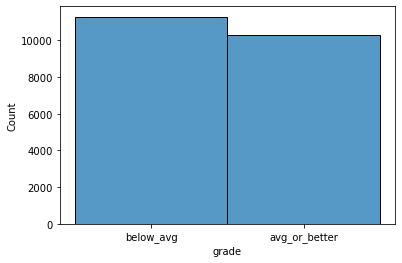

In [1197]:
sns.histplot(hp_df['grade'])

## Floors

<AxesSubplot:xlabel='floors', ylabel='Count'>

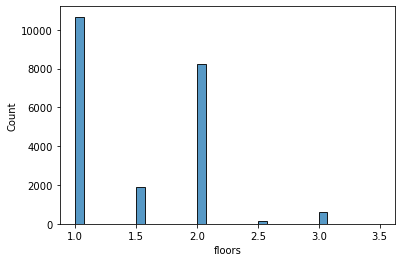

In [1198]:
sns.histplot(hp_df['floors'])

In [1199]:
hp_df['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

Binning floors to 2 categories: One floor and more than one floor.

In [1200]:
for i in range(0, len(hp_df)):
    if hp_df.loc[i, 'floors'] <= 1.0:
        hp_df.loc[i,'floors'] = 'one'
    else: 
        hp_df.loc[i, 'floors'] = 'more_than_one'

<AxesSubplot:xlabel='floors', ylabel='Count'>

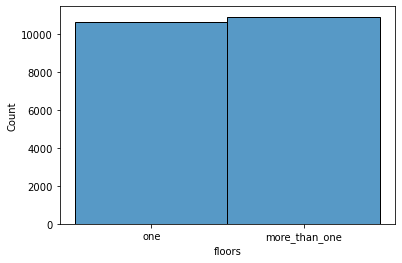

In [1201]:
sns.histplot(hp_df['floors'])

## Dropping columns:

For now the columns Unnamed, id, date and long, lat will be dropped from the dataframe.

In [1202]:
col_drop = ['Unnamed: 0',\
            'id',\
            'date',\
           'long',\
            'sqft_basement',\
            'yr_renovated',\
           'lat']   
# 'Unnamed: 0' : id from import without information
# 'id': random or consequtive values without values
# 'date': probably the date the house was added to the database, no additional information for houseprice
# 'lang', 'lat': Geografical data, not usable in linear regression like this, can be converted to zones using knn. 
#    Task for later. But zip codes are enough, probably


In [1203]:
hp_df = hp_df.drop(col_drop, axis= 1)

## Changing datatypes


The format of the features are mostly numerical (int or float). Many of the variables have to be transformed to category to give meaningful results in a regression.
These are:

'zipcode, 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade'

In [1204]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   bathrooms      21597 non-null  float64
 2   sqft_living    21597 non-null  int64  
 3   sqft_lot       21597 non-null  int64  
 4   floors         21597 non-null  object 
 5   waterfront     21597 non-null  int64  
 6   view           21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  yr_built       21597 non-null  int64  
 11  zipcode        21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  price          21597 non-null  int64  
 15  distanceM      21597 non-null  float64
 16  renovated      21597 non-null  object 
 17  basement       21597 non-null  object 
dtypes: flo

In [1205]:
# From the pairplot we can see which columns are categorical/dummies:
#  bedrooms, bathrooms, floors, waterfront, view, condition, grade

cat_var = ['zipcode', 'floors', 'waterfront', 'view', 'condition', 'grade']
hp_df[cat_var] = change_to_cat(cat_var)

# Checking correlation of numerical variables

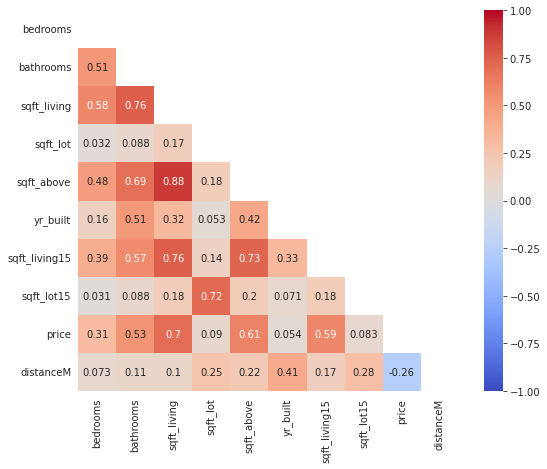

In [1206]:
  print_cor_mat(hp_df)    

The features should not be correlated in order to fulfill the asumtions of linear regression.
As expected there is a lot of correlation between sqf_above, sqf_living and other measures of size. 

We drop sqf_above as correlation is over the threshold of 0.8.

In [1207]:
hp_df = drop_above_threshold(hp_df, 0.80)

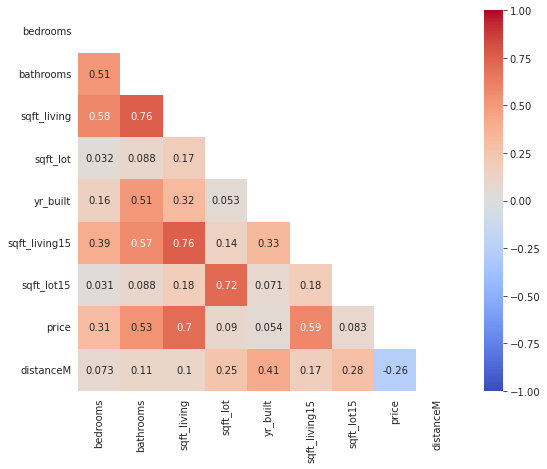

In [1208]:
print_cor_mat(hp_df)

The new dataframe does not contain anymore variables with a higher correlation than 0.8.

# Normalization

## Histograms
To check for the assumtion of normal distributions we check the histograms of the numerical variables

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'distanceM'}>]], dtype=object)

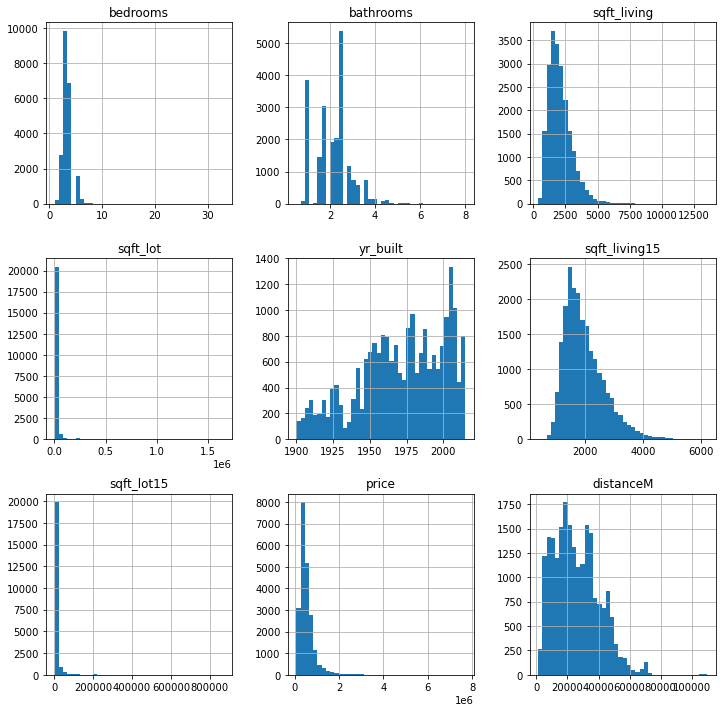

In [1209]:
print_hist(hp_df)

All numerical varibales are non-normaly distributed and need to be transformed. 

## Transforming to normal distribution

In [1210]:
numerical_vars = get_num_attributes(hp_df)

For the transformation of the variables the Quantile Transformer is applied. 

In [1211]:
hp_df, transformed_cols = transform_num_attr(hp_df)

array([[<AxesSubplot:title={'center':'bedrooms_transformed'}>,
        <AxesSubplot:title={'center':'bathrooms_transformed'}>,
        <AxesSubplot:title={'center':'sqft_living_transformed'}>],
       [<AxesSubplot:title={'center':'sqft_lot_transformed'}>,
        <AxesSubplot:title={'center':'yr_built_transformed'}>,
        <AxesSubplot:title={'center':'sqft_living15_transformed'}>],
       [<AxesSubplot:title={'center':'sqft_lot15_transformed'}>,
        <AxesSubplot:title={'center':'distanceM_transformed'}>,
        <AxesSubplot:>]], dtype=object)

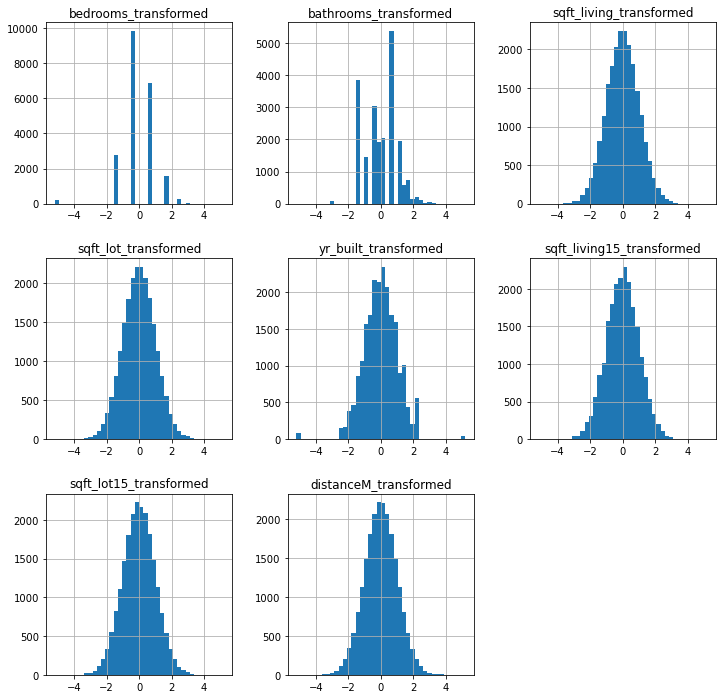

In [1212]:
print_hist(hp_df)

After transformation all numerical input variables display a normal distribution.

## Remove outliers

The Datasets contains a few datapoints that can described as outliers. One house for example as 33 rooms while the average amount of rooms is around 3. Using the two time the Interquartile range whe remove the outliers. 

In [1213]:
transformed_cols

['bedrooms_transformed',
 'bathrooms_transformed',
 'sqft_living_transformed',
 'sqft_lot_transformed',
 'yr_built_transformed',
 'sqft_living15_transformed',
 'sqft_lot15_transformed',
 'distanceM_transformed']

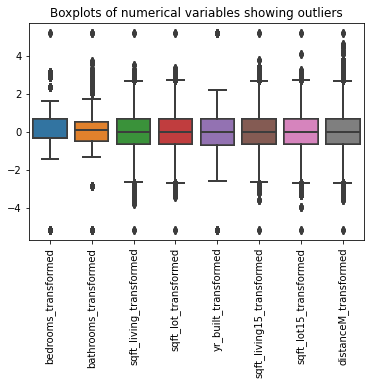

In [1214]:
for i in transformed_cols:
    sns.boxplot(data=hp_df[transformed_cols]).set(title='Boxplots of numerical variables showing outliers')
    plt.xticks(rotation=90)

In [1215]:
 len_before = hp_df.shape[0]

In [1216]:
for i in transformed_cols: 
    hp_df = remove_outlier(hp_df, i, threshold=2)

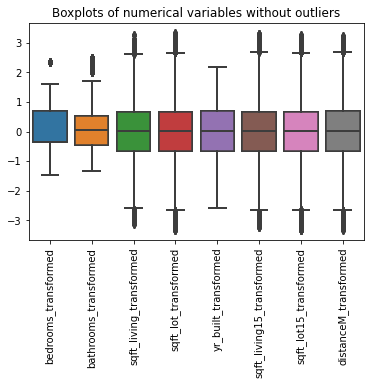

In [1217]:
for i in transformed_cols:
    sns.boxplot(data=hp_df[transformed_cols]).set(title='Boxplots of numerical variables without outliers')
    plt.xticks(rotation=90)

In [1218]:
len_after = hp_df.shape[0]

In [1219]:
print(f'Of the original dataset {round(len_after/len_before * 100, 2)}% of rows remain')

Of the original dataset 97.46% of rows remain


## One-hot encode categorical variables

In [1220]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21048 entries, 0 to 21595
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   floors                     21048 non-null  category
 1   waterfront                 21048 non-null  category
 2   view                       21048 non-null  category
 3   condition                  21048 non-null  category
 4   grade                      21048 non-null  category
 5   zipcode                    21048 non-null  category
 6   renovated                  21048 non-null  object  
 7   basement                   21048 non-null  object  
 8   bedrooms_transformed       21048 non-null  float64 
 9   bathrooms_transformed      21048 non-null  float64 
 10  sqft_living_transformed    21048 non-null  float64 
 11  sqft_lot_transformed       21048 non-null  float64 
 12  yr_built_transformed       21048 non-null  float64 
 13  sqft_living15_transformed  2104

In [1221]:
hp_df, dummies = transform_to_dummies(hp_df)

['floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode', 'renovated', 'basement']


# Modeling

## First Linear Model including Numerical and Categorical Variables as Dummies

We're splitting into X and y (predictors and target variable).


In [1222]:
hp_df['price'] = load_df()['price']

In [1223]:

X,y = Xy_split(hp_df, 'price') 

We're creating train and test-sets.

In [1224]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=100)

We're scaling the data using Standard Scaler.

In [1225]:
X_test_scaled, X_train_scaled = scale_df(X_train, X_test, X)
#dummies, X_test_scaled, X_train_scaled

(14733, 90) (6315, 90)


We're concatenating the data scaled numerical data with the categorical variables.

We're modeling using linear regression and desplaying key indicators to interpret the model fit.

In [1226]:
model, y_pred, y_pred_train = model_reg(X_train_scaled, X_test_scaled, y_train, y_test)
 
m1 = model
m1_result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

In [1227]:
m1_result.describe()

,y_test,y_pred
count,6.315000e+03,6.315000e+03
mean,5.308798e+05,5.308580e+05
std,3.398223e+05,2.916005e+05
min,7.800000e+04,-7.704871e+04
25%,3.200000e+05,3.293174e+05
50%,4.495000e+05,4.898435e+05
75%,6.400000e+05,6.852647e+05
max,7.060000e+06,2.329832e+06


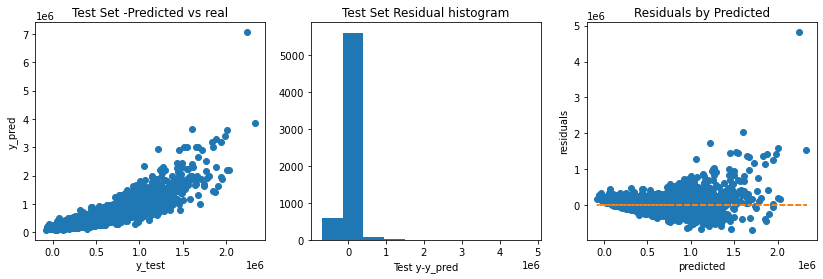

In [1228]:
plot_model_stats(y_test, y_pred)

The scatterplot of the target variable and the predicted variables displays a obvious linear trend. Risiduals seem to be normaly distributed. The Residual are not perfectly randomly distributed around 0, but overall the model seems to be okay. 

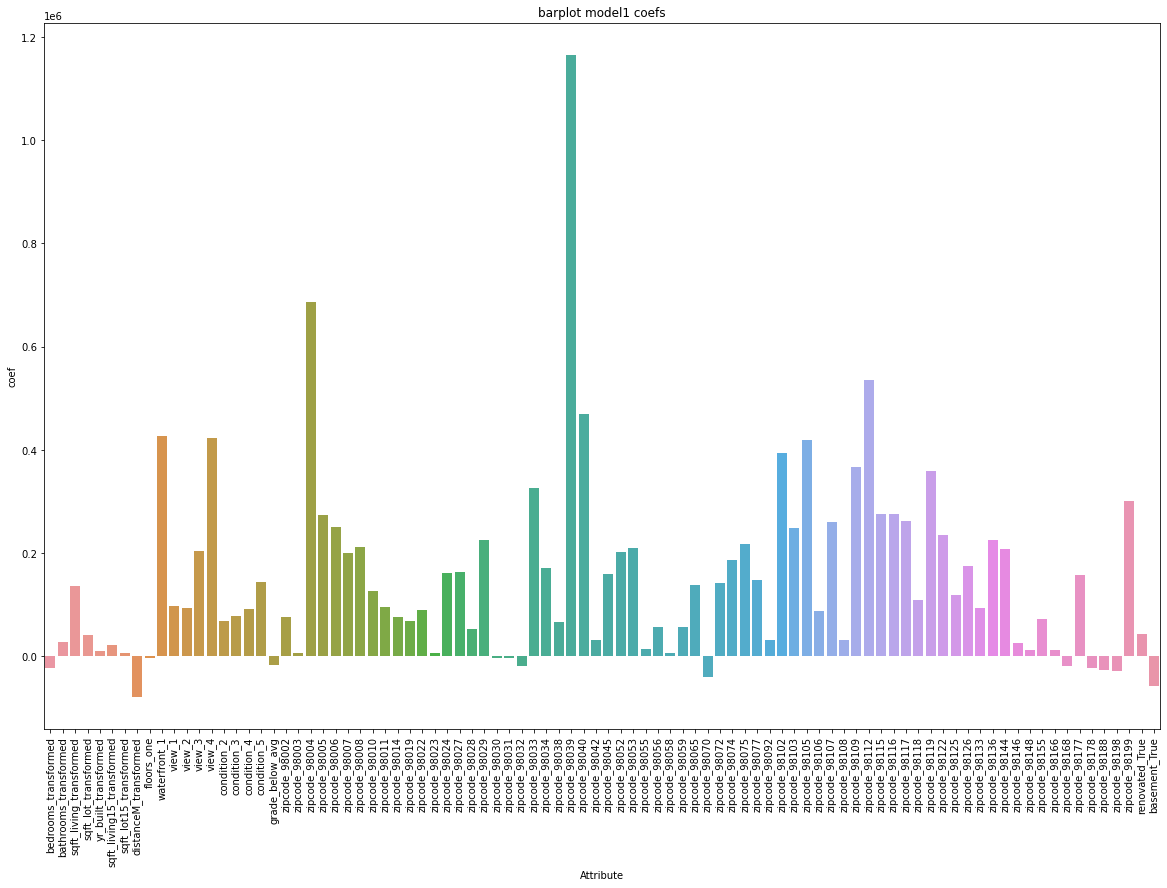

In [1229]:
m1_coef = get_model_coef(X_train, model)

plt.figure(figsize=(20,13))
sns.barplot(data=m1_coef, x='Attribute', y='coef').set(title='barplot model1 coefs')
plt.xticks(rotation=90)
plt.savefig('barplot model1 coefs.png')

In [1230]:
m1_teststats = get_testresults(X_train_scaled,
    X_test_scaled,
    X_test,
    y_test,
    y_pred,
    y_pred_train)
m1_teststats

,mse_train,mse_test,rmse_test,mae_test,R2_test,R2_train,Adj_R2
0,2.621508e+10,2.832963e+10,168314.076282,99576.752103,0.754639,0.769961,0.751091


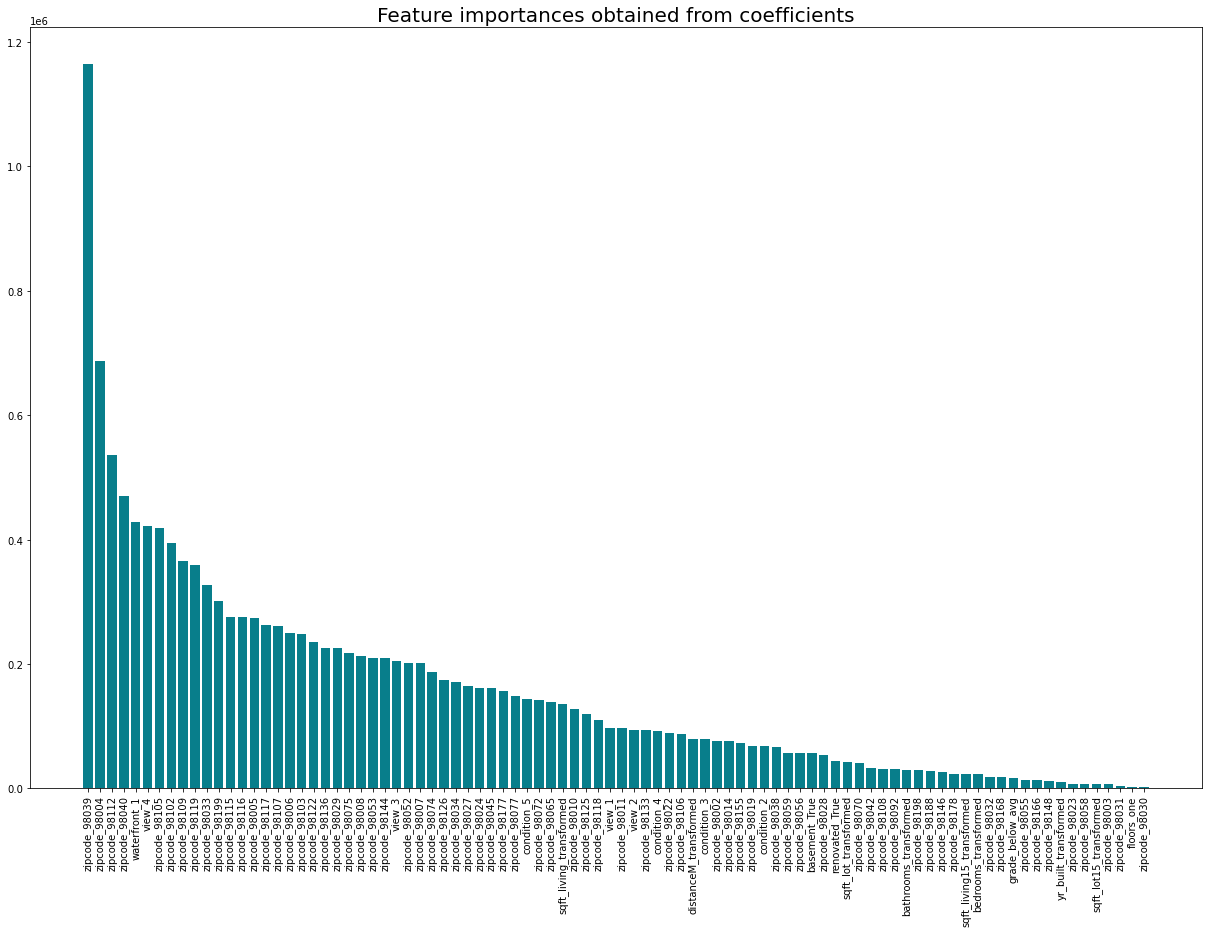

<Figure size 1440x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1231]:
m1_feature_importance = get_feature_importance(X_train, model)
plot_m1_feature_imp = plot_feature_importance(m1_feature_importance)
plt.savefig('Data/M1_feature_imp.png')

In [1232]:
m1_feature_importance.nlargest(10, 'Importance')


,Attribute,Importance
42,zipcode_98039,1.165619e+06
21,zipcode_98004,6.864954e+05
66,zipcode_98112,5.359005e+05
43,zipcode_98040,4.701242e+05
9,waterfront_1,4.276332e+05
13,view_4,4.223787e+05
61,zipcode_98105,4.187590e+05
59,zipcode_98102,3.938166e+05
65,zipcode_98109,3.662622e+05
71,zipcode_98119,3.595917e+05


The Top 10 most important features are mostly zipcodes. Also waterfront and view play an important role.

## Get P-values from model 

To filter the significant columns we get the p-value from the linear regression. If it is higher than 0.5 the column is dropped.

In [1233]:
m1_pvalues = get_pvalues(X_train, X_train_scaled, y_train)

In [1234]:
m1_pvalues

,Attribute,pvalue,coef
const,const,6.925977e-12,const
x1,bedrooms_transformed,1.745964e-34,x1
x2,bathrooms_transformed,7.694592e-33,x2
x3,sqft_living_transformed,0.000000e+00,x3
x4,sqft_lot_transformed,2.493035e-29,x4
...,...,...,...
x86,zipcode_98188,1.825163e-01,x86
x87,zipcode_98198,7.925799e-02,x87
x88,zipcode_98199,3.427730e-39,x88
x89,renovated_True,2.116590e-09,x89


In [1235]:
X = drop_non_significant(X, m1_pvalues)

From orginally 90 features 70 features remain.


## 2d linear Model only including variabels that had a siginificant p-value in the 1st Model

In [1236]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=100)

In [1237]:
X_train_num = X_train.select_dtypes(['float64'])
X_test_num = X_test.select_dtypes(['float64'])
X_train_cat = X_train.select_dtypes(['uint8'])
X_test_cat = X_test.select_dtypes(['uint8'])
print(X_train_num.shape, X_test_num.shape, X_train_cat.shape, X_test_cat.shape)

(14733, 7) (6315, 7) (14733, 63) (6315, 63)


In [1238]:
std_scaler=StandardScaler().fit(X_train_num)
X_train_scaled=std_scaler.transform(X_train_num)
X_test_scaled=std_scaler.transform(X_test_num)

In [1239]:
X_train_scaled = np.concatenate((X_train_scaled, np.asarray(X_train_cat)), axis = 1) 
X_test_scaled = np.concatenate((X_test_scaled, np.asarray(X_test_cat)), axis =1)
print(X_train_scaled.shape, X_test_scaled.shape)

(14733, 70) (6315, 70)


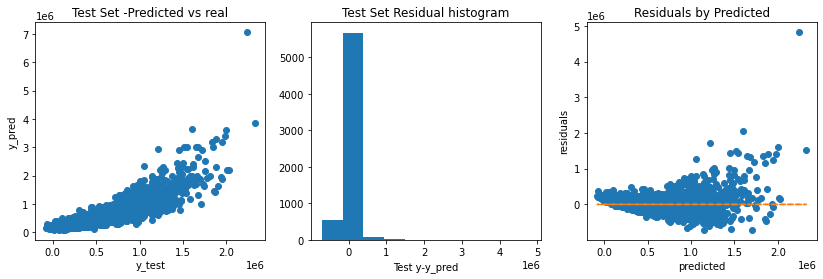

In [1240]:
model, y_pred, y_pred_train = model_reg(X_train_scaled, X_test_scaled, y_train, y_test)
model1 = model
m2__result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
plot_m1_stats = plot_model_stats(y_test, y_pred)
plt.savefig('Data/plot_m1_stats.png')

In [1241]:
m2_pvalues = get_pvalues(X_train, X_train_scaled, y_train)

In [1242]:
m2_coefs = get_model_coef(X_train, model)

In [1243]:
m2_teststats = get_testresults(X_train_scaled,
    X_test_scaled,
    X_test,
    y_test,
    y_pred,
    y_pred_train)
m2_teststats

,mse_train,mse_test,rmse_test,mae_test,R2_test,R2_train,Adj_R2
0,2.628648e+10,2.838953e+10,168491.925149,99554.193814,0.75412,0.769334,0.751363


In [1244]:
m2_teststats.to_csv('Data/m2_teststasts.csv')

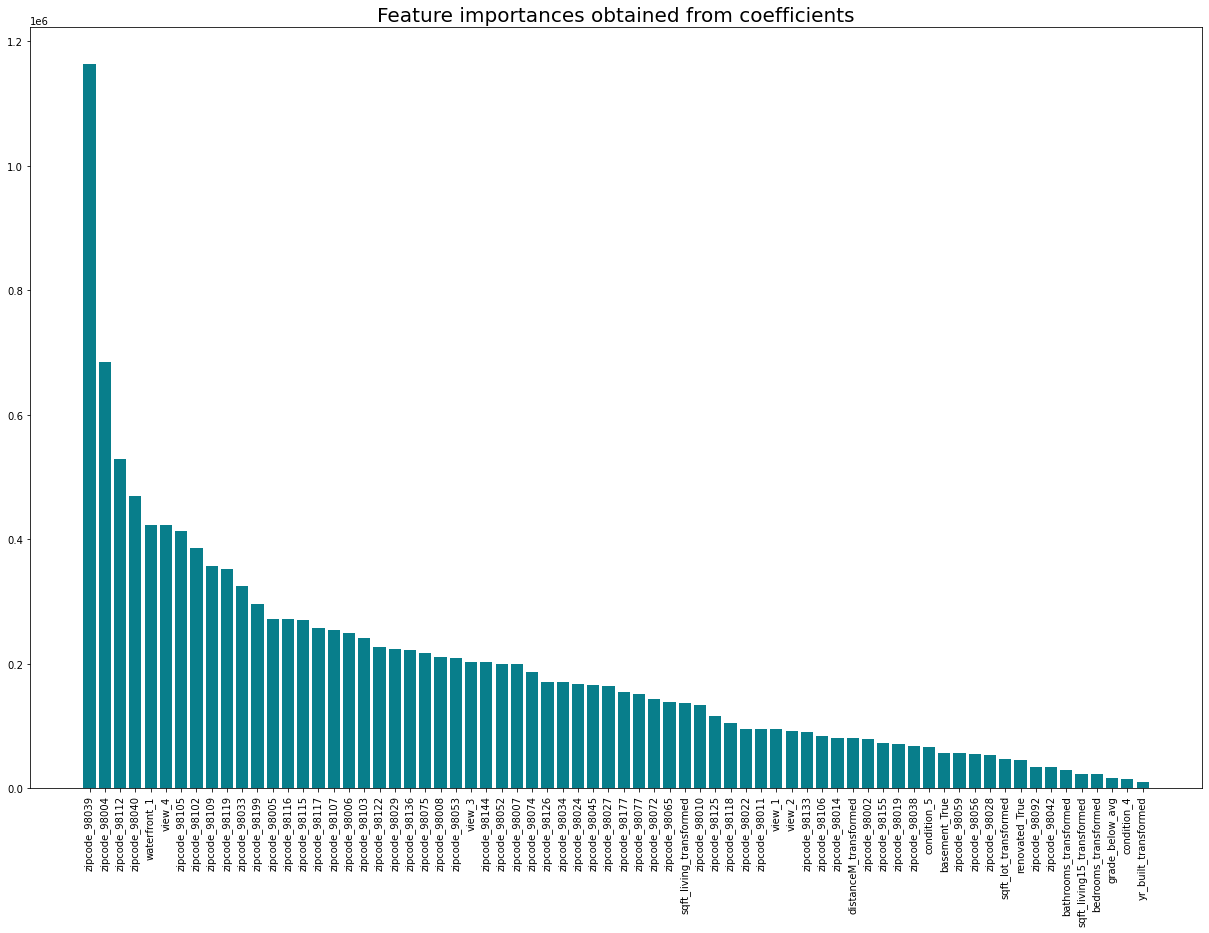

<Figure size 1440x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1245]:
m2_feature_importance = get_feature_importance(X_train, model)
plot_m2_feat_imp =  plot_feature_importance(m2_feature_importance)
plt.savefig('Data/plot_m1_feat_imp.png')

In [1246]:
m2_feature_importance.nlargest(10, 'Importance')

,Attribute,Importance
33,zipcode_98039,1.164414e+06
16,zipcode_98004,6.845557e+05
53,zipcode_98112,5.285991e+05
34,zipcode_98040,4.687860e+05
7,waterfront_1,4.230986e+05
11,view_4,4.224884e+05
49,zipcode_98105,4.130036e+05
47,zipcode_98102,3.853240e+05
52,zipcode_98109,3.572934e+05
58,zipcode_98119,3.516615e+05


## Saving model results for later use:

In [1247]:
#features_importances.to_csv('FinalModelFeatureImportance.csv')

In [1248]:
m1_feature_importance.to_csv('Data/final_m1_feature_importance.csv')
m2_feature_importance.to_csv('Data/final_m2_feature_importance.csv')

In [1249]:
#sign_cols = model.pvalues[1:len(model.pvalues)]  # remove constant
#sign_cols = pd.DataFrame([sign_cols])

m1_pvalues.to_csv('Data/model1_pvalues.csv')
m2_pvalues.to_csv('Data/model1_pvalues.csv')

# Results:

The results of the linear regression show that the size of the different components of a house (bathrooms, sqft_living, sqft_lot...) have a significant effect on the price of a house. On the other hand we see that much more important than size is the location of the House. The travel distance to the city center of Seattle also has a high influence, but waterfront and view have a higher influence. Many Zipcodes seem to be popular for other reasons than the quality of the house (and demand increases price). 

To visualize this phenomenon we extract the importance of the zipcodes and it to each house. Then we map the geographic location and the importance per zipcode. When we compare this graph to the Average price per zipcode we see that there are significant differences. 

In [1250]:
#rank Importance into Quantiles
m1_coef['zip_rank'] = pd.qcut(m1_coef['coef'], q=4, labels=["low", "medium", "high", "premium"])

In [1251]:
# Get only zipcodes to compare:
importance_zipcode = m1_coef[m1_coef['Attribute'].str.startswith('zipcode')]
importance_zipcode['zipcode']=importance_zipcode['Attribute'].str.replace('zipcode_', '')
importance_zipcode['zipcode'] =importance_zipcode['zipcode'].astype('int')
df_result = pd.merge(importance_zipcode[['zipcode', 'zip_rank']], load_df(), on='zipcode' )

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\1587380442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_zipcode['zipcode']=importance_zipcode['Attribute'].str.replace('zipcode_', '')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\1587380442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_zipcode['zipcode'] =importance_zipcode['zipcode'].astype('int')


## The role of Zipcodes for price determination

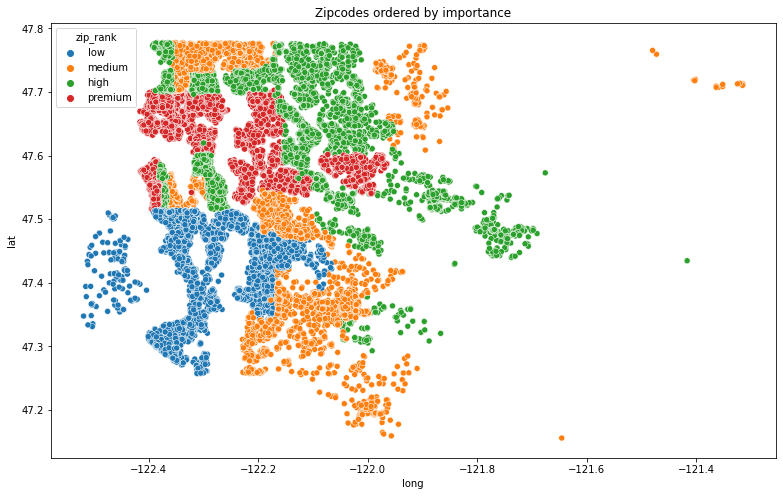

In [1252]:
plt.figure(figsize=(13,8))
plot_zipcodes_imp =  sns.scatterplot(data=df_result, x='long', y='lat', hue='zip_rank').set(title= 'Zipcodes ordered by importance')
plt.savefig('Data/plot_zipcodes_imp.png')

## Average prices per zipcode ranked into 4 categories

In [1253]:
avg_price_zip = load_df()[['zipcode', 'price']].groupby('zipcode').mean('price')
avg_price_zip['avg_price_zip']=avg_price_zip['price']
avg_price_zip.drop('price', axis=1, inplace=True)
merged_av_price = pd.merge(avg_price_zip[['avg_price_zip']], load_df(), on='zipcode')
merged_av_price['price_ranked_zip'] = pd.qcut(merged_av_price['avg_price_zip'], q=4, labels=["low", "medium", "high", "premium"])

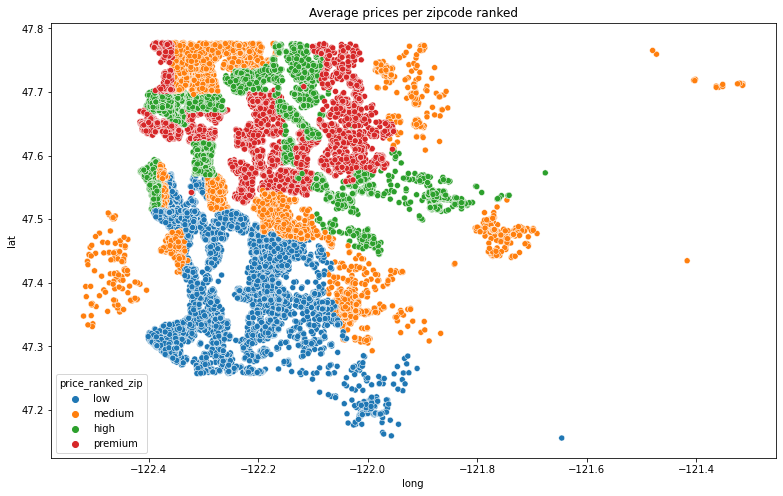

In [1254]:
plt.figure(figsize=(13,8))
plot_avg_prices_zipcode = sns.scatterplot(data=merged_av_price, x='long', y='lat', hue='price_ranked_zip').set(title='Average prices per zipcode ranked')
plt.savefig('Data/Average prices per zipcod ranked.png')

   ## Additional visualization:

In [1255]:
hp_df_org = load_df()
hp_df_org['price_rank'] = pd.qcut(load_df()['price'], q=4, labels=["low", "medium", "high", "premium"])

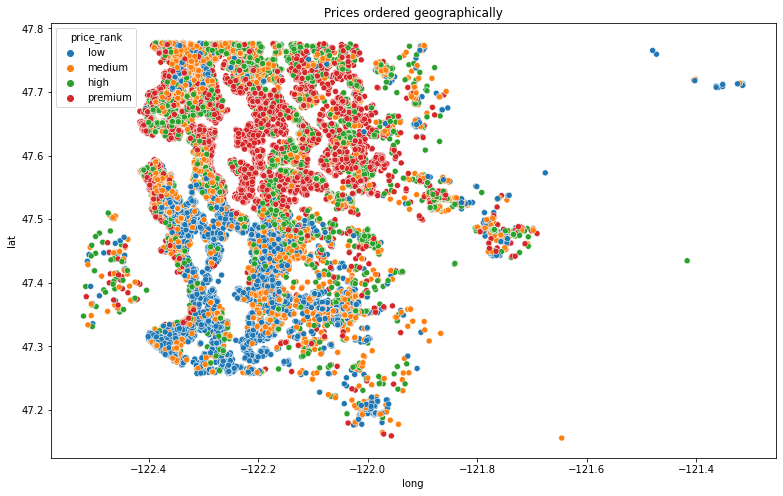

In [1256]:
plt.figure(figsize=(13,8))
plot_prices_geo = sns.scatterplot(data=hp_df_org, x='long', y='lat', hue='price_rank').set(title= 'Prices ordered geographically')
plt.savefig('Data/prices_geo.png')